# Overview
In the last lecture and lab, we went over how we can use multiple regression to estimate how much a voxel responds to each stimulus in an experiment, and how to use bootstrap tests and confidence intervals to determine if a specific condition activates a voxel more than another condition.

# Goals
We will first briefly go over the concept of confidence intervals and the multiple comparisons problem. 

In the second half of the lecture, we will talk about the regression models as predictive models. We can use regression models to predict the activity for each conditions. We will see in this lab how we can perform this prediction. We will also see how we can use complex stimulus that is not neatly categorized into conditions. Learning the brain responses to the different properties of the stimulus will allow us to build models that can predict the activity for new, unseen conditions.

- Neuroscience concepts
    - Building a predictive model of brain activity
    - Using feature spaces to represent the properties of complex stimulus
    - Modeling brain responses as a function of stimulus features
- Coding concepts
    - Implementing splitting data into testing and training sets
- Datascience concepts
    - Multiple comparisons problem
    - Predicting held out data
    - Testing and training sets
    - Testing model performance (using correlation)

In [2]:
# Imports
import neurods
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel
import cortex
# Configure defaults for plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline
from scipy.stats import zscore

In [3]:
# Some functions that we defined last week
from numpy.linalg import inv
def OLS(X, Y):
    return np.dot(inv(np.dot(X.T, X)), np.dot(X.T, Y))

def randomize_OLS(X, Y):
    n = X.shape[0]
    sample_index = np.random.choice(n,n)
    return OLS(X[sample_index], Y[sample_index])

def randomize_OLS_for_fMRI(X, Y):
    n = X.shape[0]
    n_blocks = int(n/5)
    block_index = np.arange(n).reshape([n_blocks, -1])
    sample_index = np.random.choice(n_blocks, n_blocks)
    sample_index = block_index[sample_index].reshape([-1])
    return OLS(X[sample_index], Y[sample_index])

# Modeling voxel responses (a recap from last week's lecture)

#### Load the same functional localizer data (two blocks of data 4 minutes each) from the past lecture:

Loading /data/shared/cogneuro88/fMRI/categories/s01_categories_01.nii.gz...
Loading /data/shared/cogneuro88/fMRI/categories/s01_categories_02.nii.gz...
Voxel responses shape: (240, 38543)


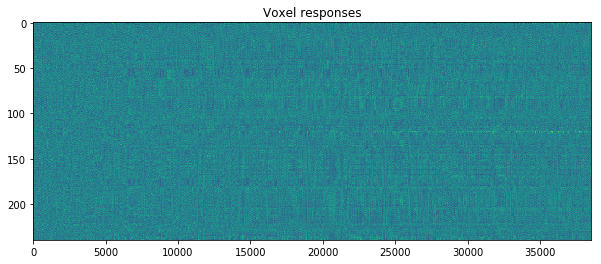

In [4]:
# Load functional localizer information
basedir = os.path.join(neurods.io.data_list['fmri'],'categories')

# Pycortex plotting information
sub, xfm = 's01', 'catloc'
cortical_voxels = cortex.db.get_mask(sub, xfm, type='cortical')

# Load fMRI data
fmri_files1 = ['s01_categories_{:02d}.nii.gz'.format(run) for run in [1,2]]
fmri_files1 = [os.path.join(basedir, f) for f in fmri_files1]

Y = np.vstack( neurods.io.load_fmri_data(fmri_files1[i], mask=cortical_voxels, do_zscore=True, dtype=np.float32)
              for i in [0, 1])
print('Voxel responses shape: {}'.format(Y.shape))

# Plot fMRI responses
plt.figure(figsize=(10,4))
plt.imshow(Y)
plt.title('Voxel responses')

#### Load the same stimuli matrix (design matrix) from the past lecture and convolve it with the hemodynamic response function to account for the slow response measured in our fMRI data: 

Experiment design variables:  ['run2', 'run3', 'conditions', 'run1']
Conditions:  ['body', 'faces', 'object', 'places', 'scrambled']
Stimuli matrix (design matrix) shape: (240, 5)
Convolved stimuli matrix (design matrix) shape: (240, 5)


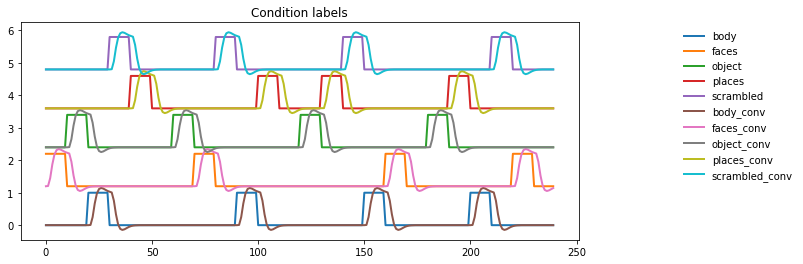

In [5]:
# Load stimuli (design matrix)
design = np.load(os.path.join(basedir,'experiment_design.npz'))
print('Experiment design variables: ', design.keys())
conditions = design['conditions'].tolist()
print('Conditions: ', conditions)

X = np.vstack([design[run] for run in ['run1','run2']])
print('Stimuli matrix (design matrix) shape: {}'.format(X.shape))

# Convolve stimuli with the hemodynamic response function (HRF) (as in Lecture08, and Lecture10)
from neurods.fmri import hrf as generate_hrf
t_hrf, hrf_1 = generate_hrf(tr=2)
n, d = X.shape
conv_X = np.zeros_like(X)
for i in range(d):
    conv_X[:,i] = np.convolve(X[:,i], hrf_1)[:n]
print('Convolved stimuli matrix (design matrix) shape: {}'.format(conv_X.shape))

# Plot stimuli (design matrix)
plt.figure(figsize=(10,4))
for i, (cond, label) in enumerate(zip(X.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

# Plot stimuli (design matrix) convolved with HRF
for i, (cond, label) in enumerate(zip(conv_X.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label+'_conv', lw=2)
    
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

#### Estimate the weights for all voxels:

shape of weights is (5, 38543)
Started server on port 3623


<WebApp(Thread-5, started 140145621165824)>

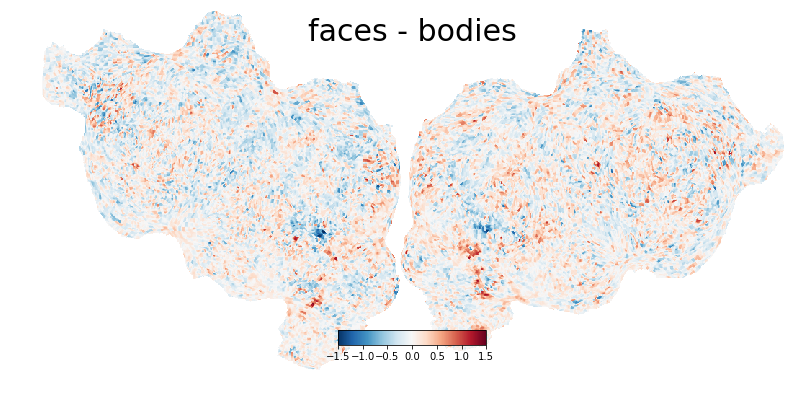

In [6]:
weights = OLS(conv_X, Y)
print('shape of weights is {}'.format(weights.shape))
faces_idx = conditions.index('faces')
body_idx = conditions.index('body')

vol = cortex.Volume(weights[faces_idx] - weights[body_idx], sub, xfm, mask = cortical_voxels,vmin = -1.5, vmax = 1.5)
__  = cortex.quickflat.make_figure(vol)
plt.suptitle('faces - bodies', fontsize = 30)
cortex.webshow(vol)

#### Contrast: faces - body and compute reliability of this difference

In [7]:
n_bootstrap = 100
difference_bootstrap = np.zeros((n_bootstrap, Y.shape[1]))

for i in np.arange(n_bootstrap):
    tmp = randomize_OLS_for_fMRI(X, Y)
    difference_bootstrap[i, :] = tmp[faces_idx, :] - tmp[body_idx, :]

**SURVEY**

Let's
- compute the 95% confidence interval of the differences in one voxel (e.g. voxel with the index 2000)
- plot the histogram

In [8]:
print(difference_bootstrap.shape)

(100, 38543)


Voxel confidence interval: [0.03896219223205534, 0.8069092218838041]


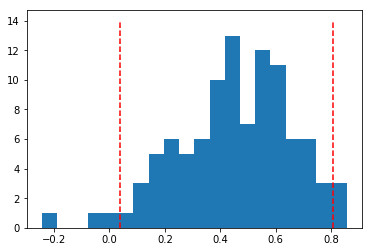

In [9]:
# Plot one voxel's difference bootstrap values as a histogram
voxel_idx = 2000
_ = plt.hist(difference_bootstrap[:, voxel_idx], 20)
ci_low = np.percentile(difference_bootstrap[:, voxel_idx], 2.5, interpolation='midpoint')
ci_up = np.percentile(difference_bootstrap[:, voxel_idx], 97.5, interpolation='midpoint')
plt.plot((ci_low, ci_low), (0, 14), 'r--') 
plt.plot((ci_up, ci_up), (0, 14), 'r--')

print("Voxel confidence interval: [{}, {}]".format(ci_low, ci_up))

In [57]:
list(np.random.choice(difference_bootstrap.shape[1], 2)) + [12518, 3761]

[10945, 25064, 12518, 3761]

0: Voxel confidence interval: [-0.24678445968363022, 0.2707646219964538]
1: Voxel confidence interval: [-0.4242379986844026, 0.49328940034119617]
2: Voxel confidence interval: [0.3185573587732183, 1.0665188716857559]
3: Voxel confidence interval: [-0.6934523618796707, -0.15367128426352375]


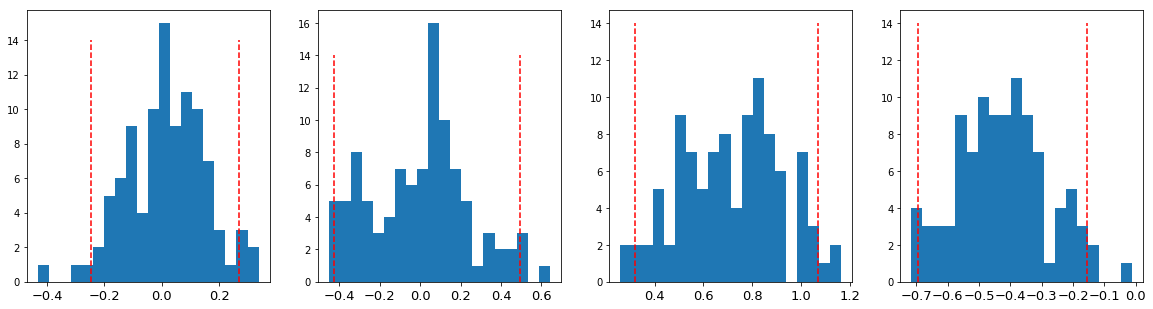

In [58]:
# Plot random voxels' difference bootstrap values as a histogram
voxel_idxs = list(np.random.choice(difference_bootstrap.shape[1], 2)) + [12518, 3761]


f, axs = plt.subplots(1, 4, figsize=(20, 5))
for ii, voxel_idx in enumerate(voxel_idxs):
    _ = axs[ii].hist(difference_bootstrap[:, voxel_idx], 20)
    ci_low = np.percentile(difference_bootstrap[:, voxel_idx], 2.5, interpolation='midpoint')
    ci_up = np.percentile(difference_bootstrap[:, voxel_idx], 97.5, interpolation='midpoint')
    axs[ii].plot((ci_low, ci_low), (0, 14), 'r--') 
    axs[ii].plot((ci_up, ci_up), (0, 14), 'r--')

    for tick in axs[ii].xaxis.get_major_ticks():
        tick.label1.set_fontsize(13)
        # tick.label1.set_fontweight('bold')
    print("{}: Voxel confidence interval: [{}, {}]".format(ii, ci_low, ci_up))

### Interpretation:

We are interested in voxel weight differences (faces - bodies) that are bigger than 0 and fall into the confidence interval. Voxels that are bigger than 0 are those where the weight estimate is bigger to faces than to bodies.

- If the lower bound of the confidence interval (ci_low) is bigger than 0, i.e., the values that are in the confidence interval are bigger than 0, then we can say with 95% certainty for this voxel  $faces > bodies$.

- If the upper bound of the confidence interval (ci_up) is smaller than 0, i.e., the values that are in the confidence interval are smaller than 0, then we can say with 95% certainty for this voxel $faces < bodies$.



Now let's do this for all voxels:
- compute the 95% confidence interval for the differences
- for each voxel plot on the flatmap $faces > bodies$
- for each voxel plot on the flatmap $faces < bodies$

In [11]:
# Compute the 95% confidence interval
confidence_interval_lower_bound = np.percentile(difference_bootstrap, 0.5, axis=0)
confidence_interval_upper_bound = np.percentile(difference_bootstrap, 99.5, axis=0)

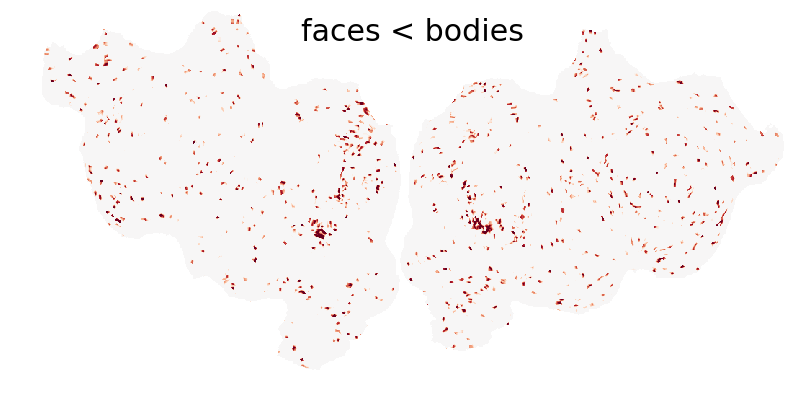

In [12]:
# Plot faces < bodies
vol = cortex.Volume((confidence_interval_upper_bound < 0)*1.0, sub, xfm,
                    mask = cortical_voxels, vmin=-1, vmax=1, with_colorbar=False)
__  = cortex.quickflat.make_figure(vol, with_colorbar=False)
plt.suptitle('faces < bodies', fontsize = 30)

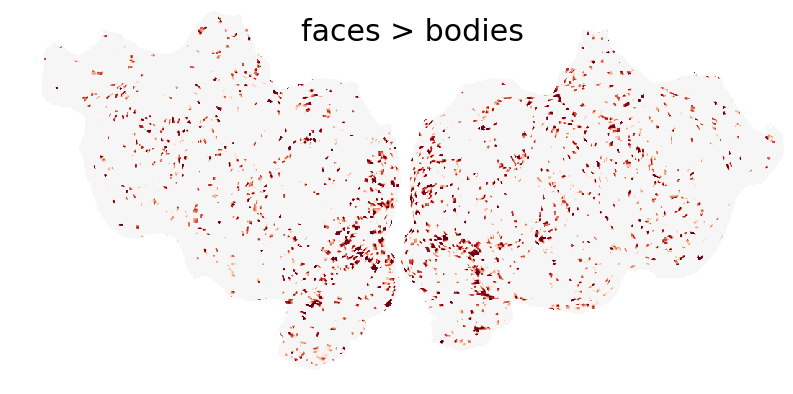

In [13]:
# Plot faces > bodies
vol = cortex.Volume((confidence_interval_lower_bound > 0)*1.0, sub, xfm,
                     mask=cortical_voxels, vmin=-1, vmax=1)
__  = cortex.quickflat.make_figure(vol, with_colorbar=False)
plt.suptitle('faces > bodies', fontsize = 30)

#### Breakout session:

- Describe what we plot here?
- What do you notice? 
- Why are there so many voxels all around the brain? 

**SURVEY Q3**

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://imgs.xkcd.com/comics/significant.png")

The comic above illustrates the importance of **multiple comparison correction**. This problem is very important in fMRI. Multiple comparison problem is the problem that if you do a lot of different statistical tests (e.g. for each of the > 30 000 voxels, we test whether faces are more activated than bodies), at least some of the tests will be significant, even if they are not really significant.

## The dead salmon study and the multiple comparisons problem

An influential study by Bennett et al. (2010) showed that a group of voxels in a dead salmon were implicated in processing social cues from images, clearly some **false positives**, i.e., an effect is marked as real or significant even though it was not. This study was designed to show the perils of failing to correct for multiple comparisons.

Here are some good blog posts about this study:
http://neuroskeptic.blogspot.com/2009/09/fmri-gets-slap-in-face-with-dead-fish.html
https://blogs.scientificamerican.com/scicurious-brain/ignobel-prize-in-neuroscience-the-dead-salmon-study/

The orinigal study:

Bennett et al. "Neural Correlates of Interspecies Perspective Taking in the Post-Mortem Atlantic Salmon: An Argument For Proper Multiple Comparisons Correction" Journal of Serendipitous and Unexpected Results, 2010

In [17]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://blogs.scientificamerican.com/scicurious-brain/files/2012/09/dead-salmon-fmri1.png")

There are several ways to correct for multiple comparisons and a big chunk of literature exists how to do multiple comparisons testing in fMRI. The most common methos used in fMRI are: Family Wise Error correction such as the Bonferroni correction, and the False Discovery Rate. The details of these methods fall beyond the scope of this lecture. **However, it is very important to do the appropriate multiple comparisons testing when conclusions about the reliability or significance of the results in fMRI are reported.**


## Predicting withheld data

To understand whether the weights of a learned model are meaningful and not due to chance only is to predict a new, previously not used dataset. The idea is that if the weights we estimated are indicative of how the brain responds to the experimental conditions, then we can use them to predict the brain response for a new dataset. Here, we introduce concepts that are very important for the statistics and machine learning fields:

- **Training dataset**: This is the part of the dataset you use to estimate your model. You can use this data as you wish. Due to **overfitting** you might want to be careful with how much of the variance of this data you want your model to predict.

- **Test dataset**: This dataset should remain untouched until the very end of your analysis, where you only use it to report your results. You should never go back to your analysis and change any parameters based on the performance of your model on the test set.

One of the big fallacies in the fMRI literature is that a lot of the studies use the same data to formulate the hypothesis (training a model) and report the involvement of a region (testing a model).

However, you should be careful to **never** use the same data to model and to test your hypotheses! 


So far, we only used two blocks of our functional localizer data. We intentionally did not use the third run of our experiment. Now, it is time to use this third run to test the regression model performance of our model:

Loading /data/shared/cogneuro88/fMRI/categories/s01_categories_03.nii.gz...
Voxel responses shape: (120, 38543)


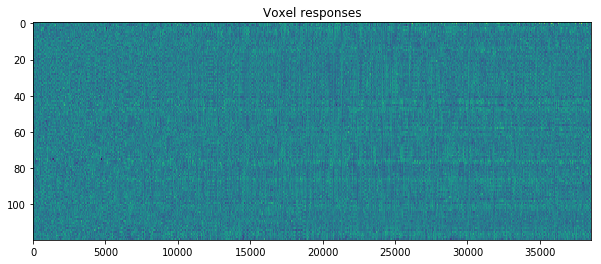

In [14]:
# Load functional localizer information
basedir = os.path.join(neurods.io.data_list['fmri'],'categories')

# Pycortex plotting information
sub, xfm = 's01', 'catloc'
cortical_voxels = cortex.db.get_mask(sub, xfm, type='cortical')

# Load fMRI data for the third run
fmri_files2 = 's01_categories_03.nii.gz'
fmri_files2 = os.path.join(basedir, fmri_files2)

Y_test = neurods.io.load_fmri_data(fmri_files2, mask=cortical_voxels, do_zscore=True, dtype=np.float32)
print('Voxel responses shape: {}'.format(Y_test.shape))

# Plot fMRI responses
plt.figure(figsize=(10,4))
plt.imshow(Y_test)
plt.title('Voxel responses')

Experiment design variables:  ['run2', 'run3', 'conditions', 'run1']
Conditions:  ['body', 'faces', 'object', 'places', 'scrambled']
Convolved stimuli matrix (design matrix) shape: (120, 5)


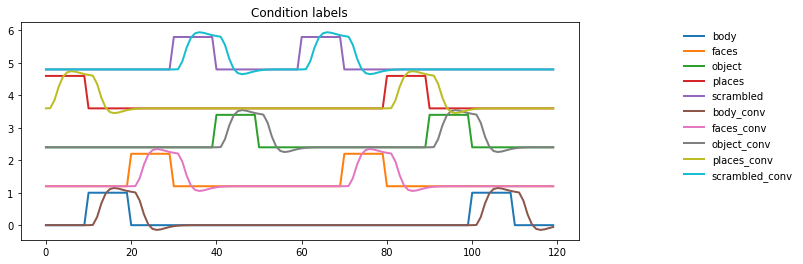

In [15]:
# Load stimuli (design matrix)
design = np.load(os.path.join(basedir,'experiment_design.npz'))
print('Experiment design variables: ', design.keys())
conditions = design['conditions'].tolist()
print('Conditions: ', conditions)

X_test = np.vstack([design[run] for run in ['run3']])

# Convolve stimuli with the hemodynamic response function (HRF) (as in Lecture08, and Lecture10)
from neurods.fmri import hrf as generate_hrf
t_hrf, hrf_1 = generate_hrf(tr=2)
n, d = X_test.shape
conv_X_test = np.zeros_like(X_test)
for i in range(d):
    conv_X_test[:,i] = np.convolve(X_test[:,i], hrf_1)[:n]
print('Convolved stimuli matrix (design matrix) shape: {}'.format(conv_X_test.shape))

# Plot stimuli (design matrix)
plt.figure(figsize=(10,4))
for i, (cond, label) in enumerate(zip(X_test.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

# Plot stimuli (design matrix) convolved with HRF
for i, (cond, label) in enumerate(zip(conv_X_test.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label+'_conv', lw=2)
    
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

#### Breakout Session
Using the weights you have estimated before and the conv_X_test predict the activity ${\bf \hat Y_{test}}$.

In [16]:
### STUDENT ANSWER
Y_hat_test = np.dot(conv_X_test, weights)

### Model performance: The correlation between the predicted and the real brain response

Now we can use correlation to see whether the predicted brain response (${\bf \hat Y_{test}}$) and the actual brain response ($\bf Y_{test}$) are similar.

In [17]:
print(Y_test.shape)
print(Y_hat_test.shape)

(120, 38543)
(120, 38543)


#### Breakout session:

- Using the compute_correlation function, compute the model performance
- make a flatmap of the model performance

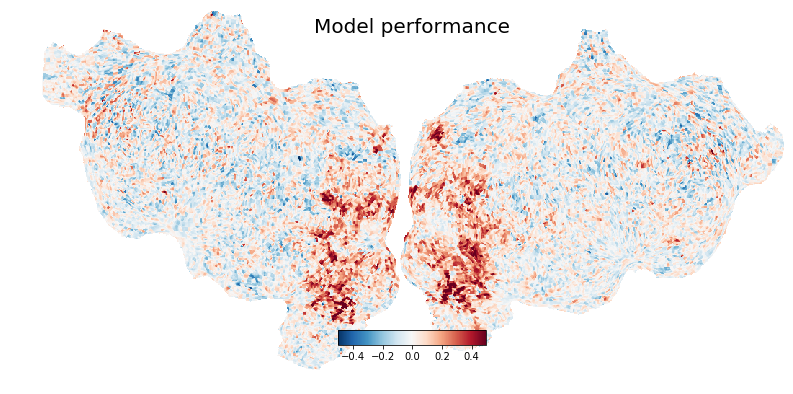

In [19]:
def compute_correlation(matrix_1, matrix_2):
    matrix_1_norm  = zscore(matrix_1)
    matrix_2_norm  = zscore(matrix_2)
    corr = np.mean(matrix_1_norm*matrix_2_norm, axis=0)
    return corr

### STUDENT ANSWER
corr = compute_correlation(Y_test, Y_hat_test)
vol = cortex.Volume(corr, sub, xfm, mask=cortical_voxels, vmin=-.5, vmax=0.5)
__  = cortex.quickflat.make_figure(vol)
plt.suptitle('Model performance', fontsize=20)

# Complex Stimuli

The approach we saw so far allows us to estimate and predict the response of each voxel to one of a few conditions. 

What if we are interested in a more complex stimuli than a few conditions only. For example, if we are interested in how the brain responses to a variety of word meanings when we speak, read, or listen to words? It would take an extremely long time to test every possible word one by one.

Another approach is therefore to image the brain activity while the subject sees a large number of different stimuli that vary along multiple dimensions. The idea is to cover the space of variability so that the contribution of each feature of the stimulus can be recovered from the data.

We will use freely available data from the Mitchell et al. 2008 Science paper: https://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/data.html

The experiment actually consist in subjects looking at words/line drawings that are presented in isolation.

In this dataset, a stimulus was presented every 10 seconds, and the activity between 4 and 8 seconds after onset was averaged, resulting in one brain image for every stimulus presentation. Each stimulus was repeated 6 times, and the repetitions of all the stimuli was averaged.

In [44]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="http://www.cs.cmu.edu/~lwehbe/files/science.png")

NOTE: KERNEL RESTART TO SAVE MEMORY!

#### Load functions into the workspace again

In [1]:
# Imports
import neurods
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel
import cortex
# Configure defaults for plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline
from scipy.stats import zscore

In [2]:
# Some functions that we defined last week
from numpy.linalg import inv
def OLS(X,Y):
    return np.dot(inv(np.dot(X.T,X)),np.dot(X.T,Y))

def randomize_OLS(X,Y):
    n = X.shape[0]
    sample_index = np.random.choice(n,n)
    return OLS(X[sample_index], Y[sample_index])

def randomize_OLS_for_fMRI(X,Y):
    n = X.shape[0]
    n_blocks = int(n/5)
    block_index = np.arange(n).reshape([n_blocks,-1])
    sample_index = np.random.choice(n_blocks,n_blocks)
    sample_index = block_index[sample_index].reshape([-1])
    return OLS(X[sample_index], Y[sample_index])

def compute_correlation(matrix_1, matrix_2):
    matrix_1_norm  = zscore(matrix_1)
    matrix_2_norm  = zscore(matrix_2)
    corr = np.mean(matrix_1_norm*matrix_2_norm, axis=0)
    return corr

In [3]:
# Load the mask
basedir = os.path.join(neurods.io.data_list['fmri'], 'word_picture')
filename = os.path.join(basedir,'s03_mask.nii')
mask = neurods.io.load_fmri_data(filename, do_zscore=False)
mask = (mask==1)

# Load the fMRI data
basedir = os.path.join(neurods.io.data_list['fmri'],'word_picture')
filename = os.path.join(basedir,'s03.nii.gz')
data = neurods.io.load_fmri_data(filename, do_zscore=True, mask=mask)
print(data.shape)

Loading /data/shared/cogneuro88/fMRI/word_picture/s03_mask.nii...
Loading /data/shared/cogneuro88/fMRI/word_picture/s03.nii.gz...
(60, 21764)


In [4]:
# Here we load the 60 words that comprise our stimuli
feature_data = np.load(os.path.join(basedir, 'features.npz'))
words = feature_data['words']

print("Here are the stimulus words: \n")
print (" - ".join(words))

Here are the stimulus words: 

airplane - ant - apartment - arch - arm - barn - bear - bed - bee - beetle - bell - bicycle - bottle - butterfly - car - carrot - cat - celery - chair - chimney - chisel - church - closet - coat - corn - cow - cup - desk - dog - door - dress - dresser - eye - fly - foot - glass - hammer - hand - horse - house - igloo - key - knife - leg - lettuce - pants - pliers - refrigerator - saw - screwdriver - shirt - skirt - spoon - table - telephone - tomato - train - truck - watch - window


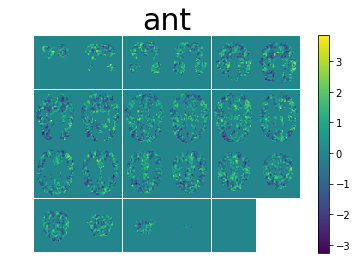

In [5]:
word_num = 1 # change the word number

sample_image = np.zeros(mask.shape)
sample_image[mask==True] = data[word_num]
h = cortex.mosaic(sample_image)
plt.colorbar();

plt.title(words[word_num], size=30)